In [82]:
import pickle

para = 'Emoid'

# Load meta dict

with open('../../AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../../BrainAgePredictWrat/' + para + 'Only10FoldSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['cand' + para + 'YesWrat']
    groups = splits['groups']
    
print(len(subids))

620


In [83]:
import numpy as np

paradigm = 'emoid'
subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

all_ts = [loadSeries('../..', paradigm, meta[subid][paradigm]) for subid in subidsNp]

print('Loading complete')

Loading complete


In [84]:
# Normalize timeseries

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print('nan {:}'.format(i))
        if np.sum(np.isinf(subj)) > 0:
            print('inf {:}'.format(i))
            
normalizeSubjects(all_ts)

print('Complete')

Complete


In [85]:
# Load WRAT for subjects

import numpy as np

idWratDict = {}

with open('../../wrat.csv') as f:
    for line in f.readlines()[1:]:
        parts = line.split(',')
        try:
            idWratDict[int(parts[0])] = int(parts[3])
        except Exception as e:
            print(parts[0])
            print(e)
            
wrat = np.array([idWratDict[subid] for subid in subids])

print(wrat.shape)
print('Complete')

603056110671
invalid literal for int() with base 10: 'NaN\n'
603317055381
invalid literal for int() with base 10: 'NaN\n'
604847970437
invalid literal for int() with base 10: 'NaN\n'
(620,)
Complete


In [33]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [86]:
# Calculate pearson matrices

all_p = np.stack([np.corrcoef(ts) for ts in all_ts])

print(all_p.shape)

(620, 264, 264)


In [87]:
# First order pearson

agesPred = np.zeros([all_p.shape[0]])

# Loop over splits
i = 0
for trainIdcs, testIdcs in groups:
    train_ps = all_p[trainIdcs].reshape(len(trainIdcs), 264*264)
    test_ps = all_p[testIdcs].reshape(len(testIdcs), 264*264)
    
    #train_ages = X_all[trainIdcs,0]
    train_ages = wrat[trainIdcs]
    
    w, _, _, _ = np.linalg.lstsq(train_ps, train_ages, rcond=None)
    
    agesPred[testIdcs] = test_ps@w
    
    print('Completed split {:}'.format(i))
    i += 1
    
print('All complete')

Completed split 0
Completed split 1
Completed split 2
Completed split 3
Completed split 4
Completed split 5
Completed split 6
Completed split 7
Completed split 8
Completed split 9
All complete


[[1.         0.35915141]
 [0.35915141 1.        ]]
15.493993107378847
11.83850694389338


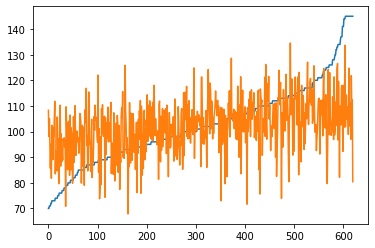

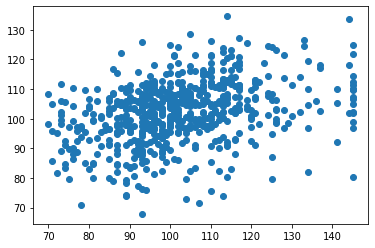

In [88]:
import matplotlib.pyplot as plt

#test_labels = X_all[:,0]
test_labels = wrat
predY = agesPred

idcs = np.argsort(test_labels[:])
yPred = predY[idcs]
y = test_labels[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)
#rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
#mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [89]:
# Save predictions

with open('../../../BrainAgePredictWrat/Wrat/LeastSquaresEmoidWratPredictions.bin', 'wb') as f:
    pickle.dump(agesPred, f)
    
print('Complete')

Complete


In [90]:
# Check predictions

with open('../../../BrainAgePredictWrat/Wrat/LeastSquaresEmoidWratPredictions.bin', 'rb') as f:
    check = pickle.load(f)
    
print(check[0:10])
print(agesPred[0:10])
print(np.count_nonzero(check == agesPred))
print(check.shape[0])

[ 99.24343139 101.83131614  95.1440329   67.8781019  105.50657864
 107.93166075 101.26973536  98.242508   106.32470914 109.24205382]
[ 99.24343139 101.83131614  95.1440329   67.8781019  105.50657864
 107.93166075 101.26973536  98.242508   106.32470914 109.24205382]
620
620


In [91]:
# Calculate 5th degree poly

all_5p = np.zeros([len(subids), 264*264*5])
all_5p[:,0:264*264] = all_p.reshape(len(subids), 264*264)

for i in range(1,5):
    all_5p[:,i*264*264:(i+1)*264*264] = all_5p[:,(i-1)*264*264:i*264*264]*all_5p[:,0:264*264]
    
print(all_5p.shape)

(620, 348480)


In [92]:
# Fifth order pearson

agesPred5 = np.zeros([all_5p.shape[0]])

# Loop over splits
i = 0
for trainIdcs, testIdcs in groups:
    train_ps = all_5p[trainIdcs].reshape(len(trainIdcs), 264*264*5)
    test_ps = all_5p[testIdcs].reshape(len(testIdcs), 264*264*5)
    
    #train_ages = X_all[trainIdcs,0]
    train_ages = wrat[trainIdcs]
    
    w, _, _, _ = np.linalg.lstsq(train_ps, train_ages, rcond=None)
    
    agesPred5[testIdcs] = test_ps@w
    
    print('Completed split {:}'.format(i))
    i += 1
    
print('All complete')

Completed split 0
Completed split 1
Completed split 2
Completed split 3
Completed split 4
Completed split 5
Completed split 6
Completed split 7
Completed split 8
Completed split 9
All complete


[[1.         0.36647953]
 [0.36647953 1.        ]]
15.0339540064612
11.39941849164028


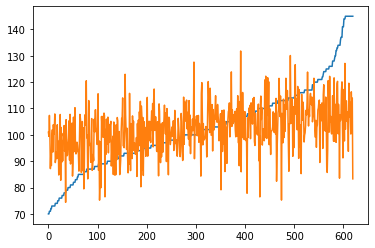

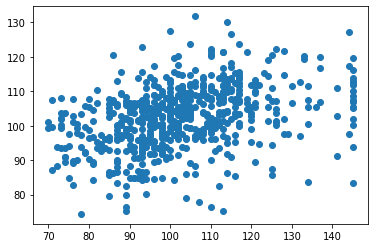

In [93]:
import matplotlib.pyplot as plt

# test_labels = X_all[:,0]
test_labels = wrat
predY = agesPred5

idcs = np.argsort(test_labels[:])
yPred = predY[idcs]
y = test_labels[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)
# rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
# mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [94]:
# Save predictions

with open('../../../BrainAgePredictWrat/Wrat/LeastSquares5EmoidWratPredictions.bin', 'wb') as f:
    pickle.dump(agesPred5, f)
    
print('Complete')

Complete


In [95]:
# Check predictions

with open('../../../BrainAgePredictWrat/Wrat/LeastSquares5EmoidWratPredictions.bin', 'rb') as f:
    check = pickle.load(f)
    
print(check[0:10])
print(agesPred5[0:10])
print(np.count_nonzero(check == agesPred5))
print(check.shape[0])

[100.79194058 102.08781796  93.47951181  85.57364876 107.49833544
 107.20559763 100.97059368 102.18685227 107.12833008 111.48557744]
[100.79194058 102.08781796  93.47951181  85.57364876 107.49833544
 107.20559763 100.97059368 102.18685227 107.12833008 111.48557744]
620
620
